<a href="https://www.kaggle.com/code/hkafrawi/mobile-a-b-testing?scriptVersionId=120544084" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
%matplotlib inline 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mobile-games-ab-testing/cookie_cats.csv


# Load and Explore the Dataset

In [2]:
df = pd.read_csv("/kaggle/input/mobile-games-ab-testing/cookie_cats.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
df['sum_gamerounds'].min(),df['sum_gamerounds'].max()

(0, 49854)

In [5]:
df['sum_gamerounds'].median()

16.0

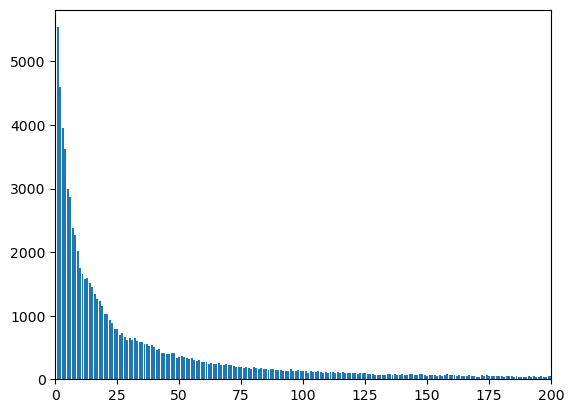

In [6]:
count_gamerounds = df.groupby('sum_gamerounds').size()
plt.bar(x=count_gamerounds.index,
       height=count_gamerounds.values)
plt.xlim(0,200)
plt.show()

In [7]:
df['version'].unique()

array(['gate_30', 'gate_40'], dtype=object)

In [8]:
df[df.duplicated()] #no duplicated enteries available

,userid,version,sum_gamerounds,retention_1,retention_7


In [9]:
df['userid'].nunique()

90189

In [10]:
df['sum_gamerounds'] = df['sum_gamerounds'].astype('int32') #downcasting datatype for preformance
df['version'] = df['version'].astype('category') #changing to category 
df2 = df.set_index('userid')

In [11]:
df2.info() # memory usage went from 2.2mb to 1.3mb

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90189 entries, 116 to 9999861
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   version         90189 non-null  category
 1   sum_gamerounds  90189 non-null  int32   
 2   retention_1     90189 non-null  bool    
 3   retention_7     90189 non-null  bool    
dtypes: bool(2), category(1), int32(1)
memory usage: 1.3 MB


# A/B Testing Retention 1 day

$$H_0: \mu_{gate30} - \mu_{gate40} = 0$$

$$H_1: \mu_{gate30} - \mu_{gate40} \neq 0$$


In [12]:
df2.query("version == 'gate_30'")['retention_1'].mean(),df2.query("version == 'gate_40'")['retention_1'].mean() 

(0.4481879194630872, 0.44228274967574577)

In [13]:
# calculate obs diff
gate_30_ret = df2.query("version == 'gate_30'")['retention_1']
gate_40_ret = df2.query("version == 'gate_40'")['retention_1']
obs_diff = gate_30_ret.mean() - gate_40_ret.mean()
obs_diff

0.005905169787341458

In [14]:
n_gate_30 = df2.query("version == 'gate_30'")['version'].count()
n_gate_40 = df2.query("version == 'gate_40'")['version'].count()

In [15]:
n_gate_30, n_gate_40

(44700, 45489)

In [16]:
p_diffs = []
size = df2.shape[0]
for _ in range(10_000):
    sample_df = df2.sample(size, replace=True)
    p_gate_30 = sample_df.query("version == 'gate_30'")['retention_1'].mean()
    p_gate_40 = sample_df.query("version == 'gate_40'")['retention_1'].mean()
    p_diffs.append(p_gate_30-p_gate_40)

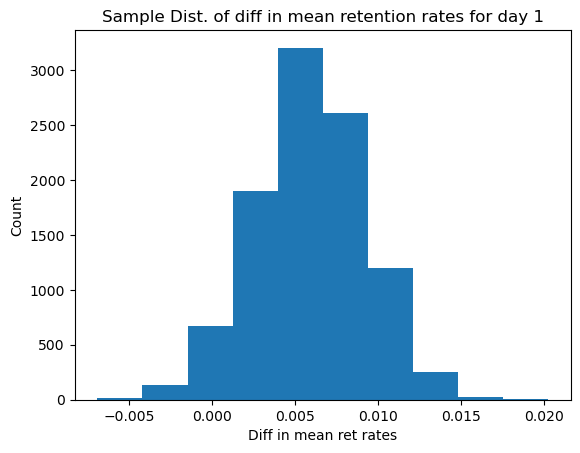

In [17]:
plt.hist(p_diffs)
plt.title("Sample Dist. of diff in mean retention rates for day 1")
plt.xlabel("Diff in mean ret rates")
plt.ylabel("Count")
plt.show()

In [18]:
null_vals = np.random.normal(0,np.array(p_diffs).std(),len(p_diffs))

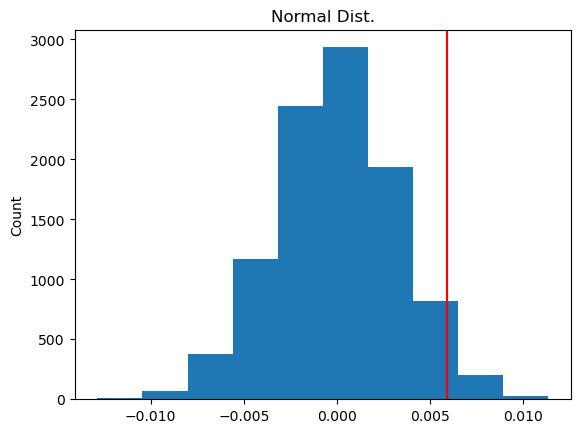

In [19]:
plt.hist(null_vals)
plt.title("Normal Dist.")
plt.ylabel("Count")
plt.axvline(x=obs_diff, color="r")
plt.show()

In [20]:
(null_vals>obs_diff).mean()

0.0362

### Conclusion A/B Testing Day 1 Retention Rates

We fail to reject $H_0$ and we are 95% confident that the gate_40 version's day 1 retention rate is not significantly different than gate_30 version's day 1 retention rate.

# A/B Testing 7 day Retention

$$H_0: \mu_{gate30} - \mu_{gate40} = 0$$

$$H_1: \mu_{gate30} - \mu_{gate40} \neq 0$$

In [21]:
# calculate obs diff
g30_ret_7 = df2.query("version == 'gate_30'")['retention_7'].mean()
g40_ret_7 = df2.query("version == 'gate_40'")['retention_7'].mean()
obs_diff = g30_ret_7 - g40_ret_7
obs_diff

0.008201298315205913

In [22]:
# n values will not change for this experiment
n_gate_30, n_gate_40

(44700, 45489)

In [23]:
p_diffss = []
size = df2.shape[0]
for _ in range(10_000):
    sampledf = df2.sample(size,replace=True)
    s_g30 = sampledf.query("version == 'gate_30'")['retention_7'].mean()
    s_g40 = sampledf.query("version == 'gate_40'")['retention_7'].mean()
    p_diffss.append(s_g30-s_g40)

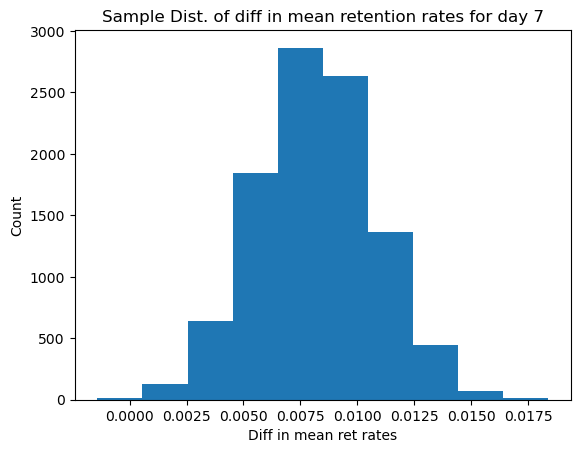

In [24]:
plt.hist(p_diffss)
plt.title("Sample Dist. of diff in mean retention rates for day 7")
plt.xlabel("Diff in mean ret rates")
plt.ylabel("Count")
plt.show()

In [25]:
null_vals = np.random.normal(0,np.array(p_diffss).std(),len(p_diffss))

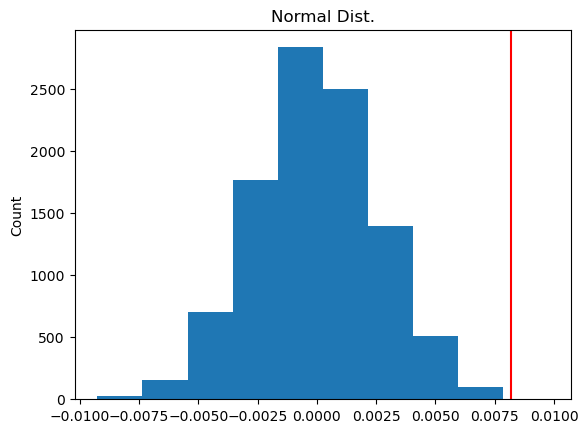

In [26]:
plt.hist(null_vals)
plt.title("Normal Dist.")
plt.ylabel("Count")
plt.axvline(x=obs_diff, color="r")
plt.show()

In [27]:
(null_vals>obs_diff).mean()

0.0005

### Conclusion A/B Testing Day 7 Retention Rates
We reject $H_0$ and we are 95% confident that the gate_40 version's day 7 retention rate is significantly different than gate_30 version's day 7 retention rate.

# Regression Analysis

In [28]:
# importing necessary libraries 
import statsmodels.api as sm

In [29]:
# add intercept
df2['intercept'] = 1

In [30]:
# add dummies for each version
df3 = df2.merge(pd.get_dummies(df2['version']),left_index=True,right_index=True)
df3.head()

,version,sum_gamerounds,retention_1,retention_7,intercept,gate_30,gate_40
userid,,,,,,,
116,gate_30,3,False,False,1,1,0
337,gate_30,38,True,False,1,1,0
377,gate_40,165,True,False,1,0,1
483,gate_40,1,False,False,1,0,1
488,gate_40,179,True,True,1,0,1


In [31]:
df4 = df3.merge(pd.get_dummies(df3['retention_7'],prefix='ret_7_'),left_index=True,right_index=True)
df4.head()


,version,sum_gamerounds,retention_1,retention_7,intercept,gate_30,gate_40,ret_7__False,ret_7__True
userid,,,,,,,,,
116,gate_30,3,False,False,1,1,0,1,0
337,gate_30,38,True,False,1,1,0,1,0
377,gate_40,165,True,False,1,0,1,1,0
483,gate_40,1,False,False,1,0,1,1,0
488,gate_40,179,True,True,1,0,1,0,1


In [32]:
# setting up MLR model
lm = sm.OLS(df4['ret_7__True'],df4[['intercept','sum_gamerounds','gate_40']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ret_7__True   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     3820.
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        23:08:17   Log-Likelihood:                -39188.
No. Observations:               90189   AIC:                         7.838e+04
Df Residuals:                   90186   BIC:                         7.841e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.1610      0.002     89.492      0.000       0.157       0.164
sum_gamerounds     0.0006   6.38e-06     87.344      0.000       0.001       0.001
gate_40           -0.0076      0.002     -3.036      0.002      -0.012      -0.003
==============================================================================
Omnibus:                    78019.664   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        338055527.847
Skew:                          -2.653   Prob(JB):                         0.00
Kurtosis:                     302.885   Cond. No.                         464.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# setting up SLR model for versions
lm = sm.OLS(df4['ret_7__True'],df4[['intercept','gate_40']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ret_7__True   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     10.01
Date:                Mon, 27 Feb 2023   Prob (F-statistic):            0.00155
Time:                        23:08:17   Log-Likelihood:                -42850.
No. Observations:               90189   AIC:                         8.570e+04
Df Residuals:                   90187   BIC:                         8.572e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1902      0.002    103.338      0.000       0.187       0.194
gate_40       -0.0082      0.003     -3.164      0.002      -0.013      -0.003
==============================================================================
Omnibus:                    21398.097   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40481.126
Skew:                           1.613   Prob(JB):                         0.00
Kurtosis:                       3.603   Cond. No.                         2.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# setting up SLR model for gamerounds played
lm = sm.OLS(df4['ret_7__True'],df4[['intercept','sum_gamerounds']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ret_7__True   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     7630.
Date:                Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                        23:08:17   Log-Likelihood:                -39193.
No. Observations:               90189   AIC:                         7.839e+04
Df Residuals:                   90187   BIC:                         7.841e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.1572      0.001    122.063      0.000       0.155       0.160
sum_gamerounds     0.0006   6.38e-06     87.349      0.000       0.001       0.001
==============================================================================
Omnibus:                    77998.831   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        337823303.074
Skew:                          -2.652   Prob(JB):                         0.00
Kurtosis:                     302.782   Cond. No.                         209.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
# setting up SLR model for gamerounds played
lm = sm.OLS(df4['sum_gamerounds'],df4[['intercept','gate_40']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sum_gamerounds   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7940
Date:                Mon, 27 Feb 2023   Prob (F-statistic):              0.373
Time:                        23:08:18   Log-Likelihood:            -6.0356e+05
No. Observations:               90189   AIC:                         1.207e+06
Df Residuals:                   90187   BIC:                         1.207e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     52.4563      0.923     56.859      0.000      50.648      54.264
gate_40       -1.1575      1.299     -0.891      0.373      -3.704       1.389
==============================================================================
Omnibus:                   431861.966   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    8346364202886.537
Skew:                         185.429   Prob(JB):                         0.00
Kurtosis:                   47129.377   Cond. No.                         2.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""